# Clustering financiero con Momentum

In [1]:
# !pip install yfinance # Para el que no tenga la librería instalada que descomente el pip install
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

En este notebook vamos a intentar aplicar las técnicas de clustering que hemos visto a los mercados financieros. En concreto, vamos a utilizar los datos de **Yahoo finance** utilizando la librería `yfinance`. Concretamente, vamos a explorar qué sucede si intentamos hacer clustering exclusivamente con los valores de retorno logarítmico frente a hacer clustering utilizando otro tipo de indicadores, como el Momentum.

$$Momentum = {C_t \over C_{t-N}},$$

$$log(Momentum) = log(C_t) - log(C_{t-N}) = \sum_{i=0}^N r_{t-i},$$

donde $r_t = log(C_t) - log(C_{t-1})$.

Vamos a definir qué valores de Momentum queremos, además del retorno logarítmico (que podría interpretarse como `Momentum@1`):

In [2]:
momentum_values = [5, 10, 20, 30, 40, 50]
lista_atributos = ["logRet"] + ["momentum@"+str(m) for m in momentum_values]

Nos definimos una función que extraiga la información que necesitamos a partir del OHLC de un activo.

In [3]:
def preprocesar_activo(activo):
    # Por empezar en algún valor, guardamos siempre a partir del 1 de enero de 2010
    ohlc = yf.download(tickers=activo, start="2010-01-01")
    
    # Calculamos los retornos logarítmicos
    ohlc["logRet"] = np.log(ohlc["Adj Close"]).diff()
    
    # Calculamos los momentums a distintas ventanas temporales
    for momentum in momentum_values:
        ohlc["momentum@"+str(momentum)] = ohlc["logRet"].rolling(momentum).sum()
        
    # Limpiamos los NaN
    ohlc.dropna(inplace = True)
    
    # Eliminamos el resto de atributos del dataset que no nos interesan
    datos = ohlc[lista_atributos]
    
    # Devolvemos el resultado en formato numpy para poder trabajarlos más cómodamente
    return datos.values, ohlc

Una vez tenemos esto, vamos a procesar una serie de activos. Para empezar, hagamos la primera prueba con solamente un activo, a ver si encontramos patrones de comportamiento similares a lo largo del tiempo.

In [4]:
activos = ["AAPL"] # Añadir en esta lista los activos que uno quiera.
lista_vectores = []
for activo in activos:
    dataset, _ = preprocesar_activo(activo)
    lista_vectores.append(dataset)
dataset = np.concatenate(lista_vectores, axis=0)
print(dataset.shape)

[*********************100%%**********************]  1 of 1 completed
(3438, 7)


No olvidemos normalizar los datos, ya que diferentes momentums se pueden mover en rangos de valores diferentes. Estos valores de `means` y `stds` los utilizaremos también para los datos de test.

In [5]:
means = dataset.mean(axis=0, keepdims=True)
stds = dataset.std(axis=0, keepdims=True)
dataset = (dataset - means) / stds

Veamos qué aspecto tiene realmente nuestro dataset.

In [6]:
df = pd.DataFrame(dataset, columns=lista_atributos)
df.sample(5)

logRet  momentum@5  momentum@10  momentum@20  momentum@30  \
1757 -0.182924   -0.177459     0.114115     0.445637     1.094083   
1197 -0.825911   -1.871640    -1.508748    -1.107576    -0.516602   
2158 -2.714034   -1.958892    -0.525271    -0.532215    -0.465490   
3272  0.985153    0.773738     1.053692    -0.207539     0.436475   
2118  0.182153    0.298385     1.707070     0.985951     0.925191   

      momentum@40  momentum@50  
1757     1.065147     1.065906  
1197     0.300960     0.204440  
2158    -0.070469     0.684024  
3272     0.948731     1.419702  
2118     0.635957     0.363264

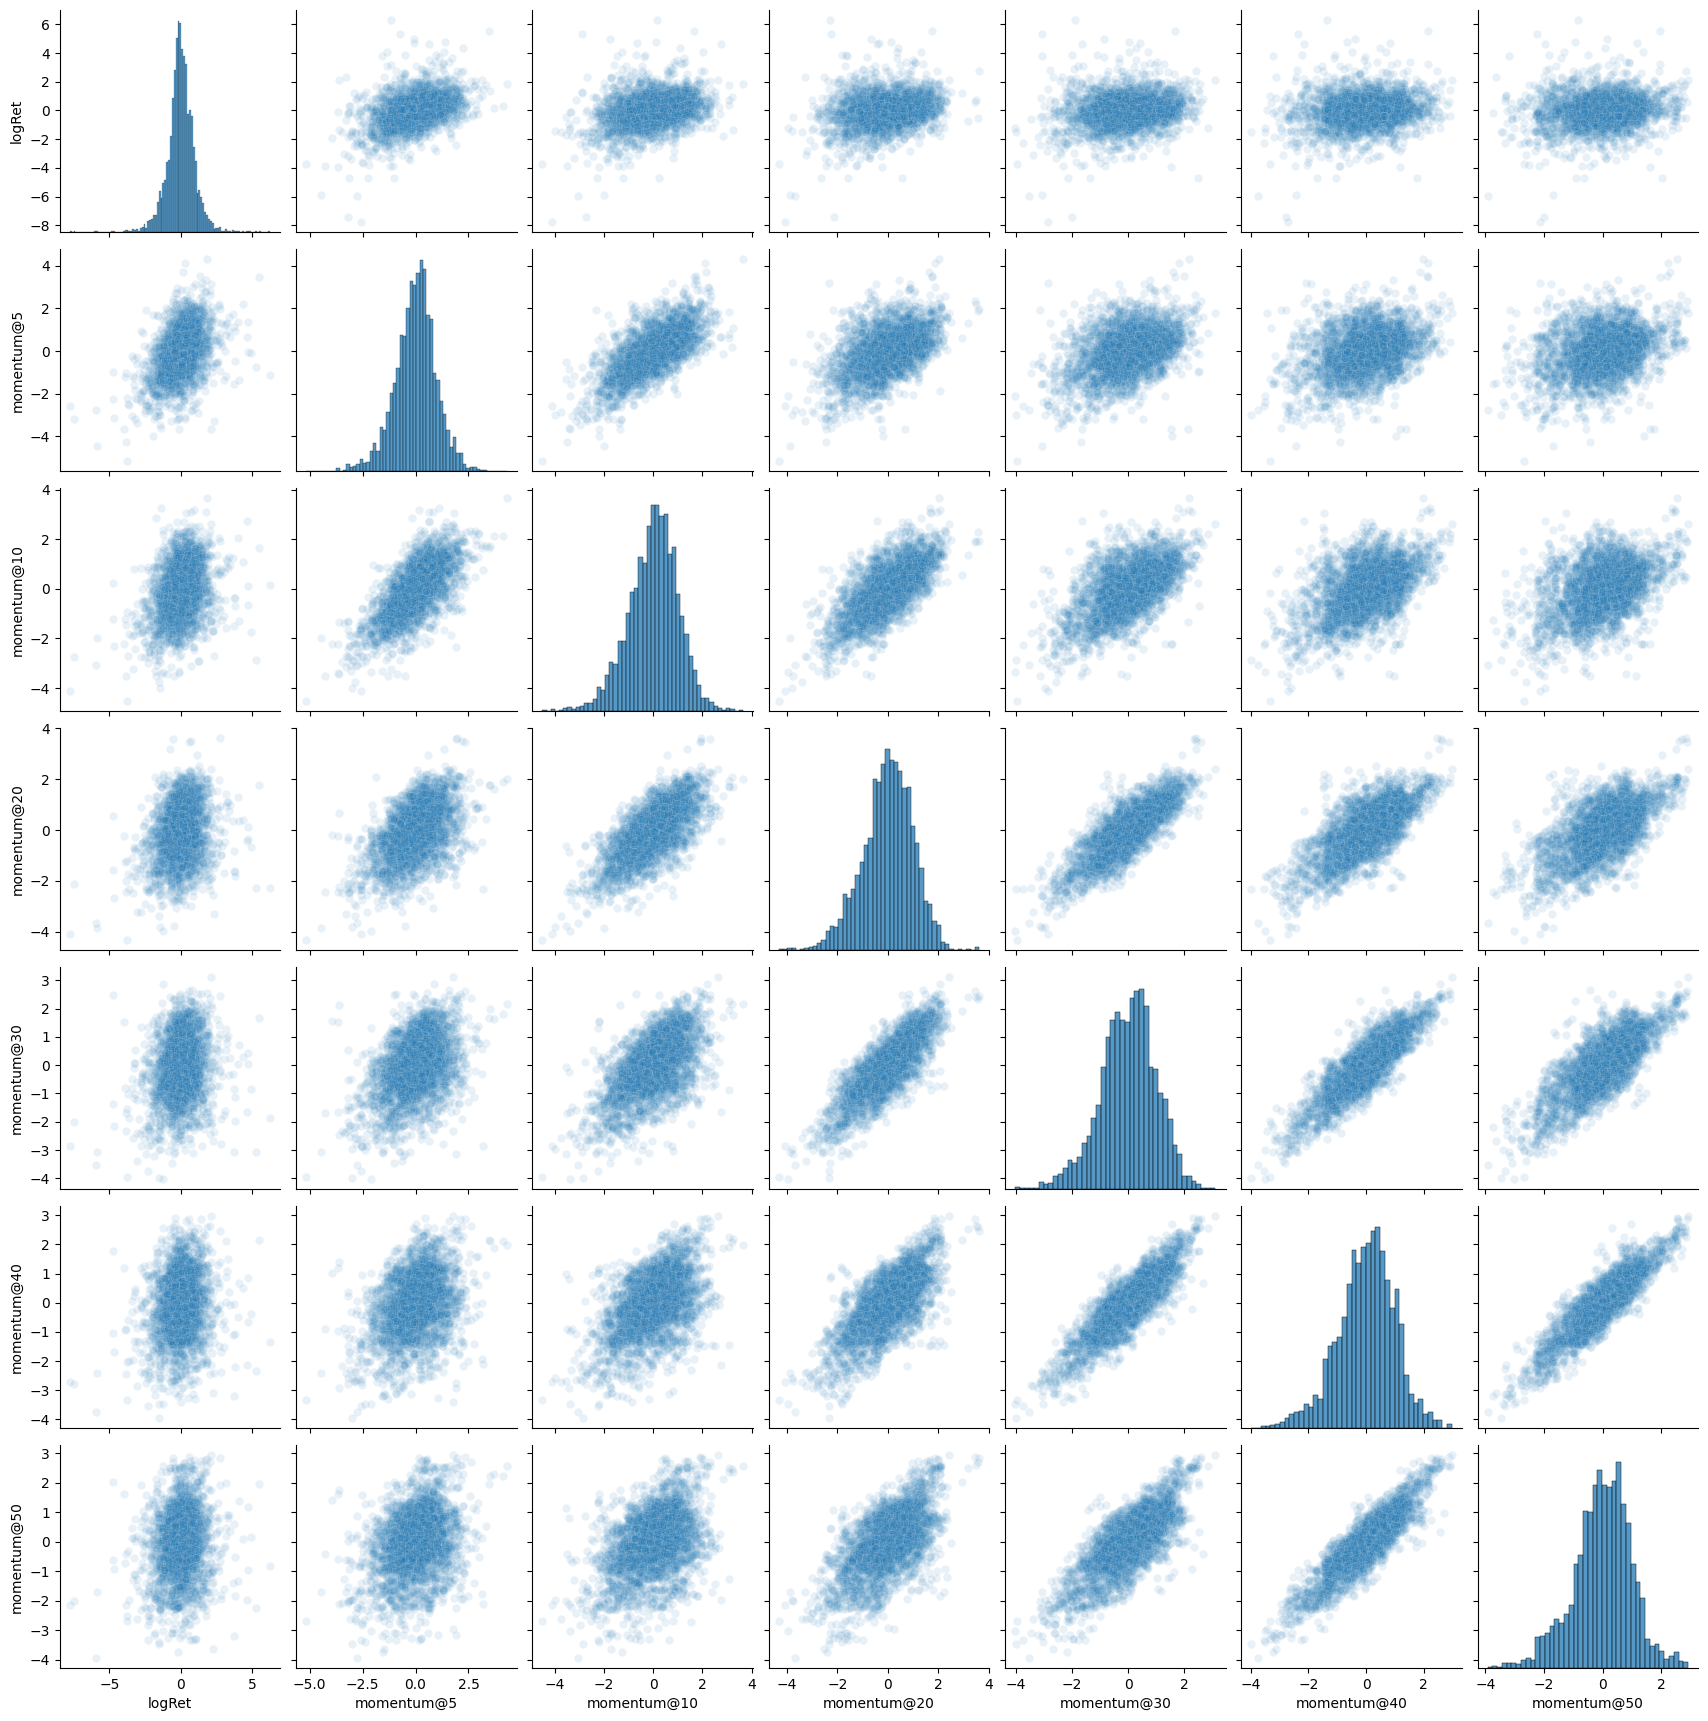

In [12]:
sns.pairplot(df, kind='scatter', plot_kws={'alpha':0.1})
plt.show()

## Clustering

Con estos datos iniciales, vamos a intentar utilizar KMeans para clusterizar. Empecemos con un clustering de `K=2`.

In [15]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
kmeans.fit(dataset)
clusters = kmeans.predict(dataset)

Visualicemos ahora los dos clusters, a ver qué aspecto tienen los datos según el cluster al que pertenezca. Usemos un boxplot para ver mediana, cuartiles y outliers.

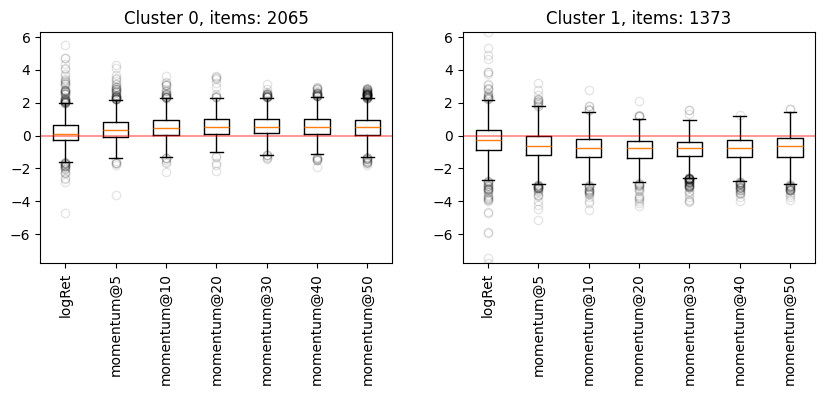

In [16]:
plt.figure(figsize=(10, 3))
for c in range(n_clusters):
    indices = (clusters == c)
    datos = dataset[indices]
    plt.subplot(1, 2, c+1)
    plt.boxplot(datos, flierprops={"alpha":0.1})
    plt.ylim(dataset.min(), dataset.max())
    plt.title("Cluster "+str(c)+", items: "+str(indices.sum()))
    plt.axhline(0.0, color="red", alpha=0.4)
    plt.xticks(range(1, dataset.shape[1]+1), lista_atributos, rotation=90)
plt.show()

**Pregunta**: ¿Qué conclusiones podemos sacar de este resultado?

Intentemos visualizar los datos por cluster en el espacio de datos en el que estamos.

In [17]:
df_clusters = pd.concat([df, pd.Series(clusters, name='cluster', index=df.index)], axis=1)
df_clusters.sample(5)

logRet  momentum@5  momentum@10  momentum@20  momentum@30  \
44   -0.954285   -1.534816    -0.744820    -0.810758     0.027002   
2090  0.395866    0.050924    -0.288408    -0.841576    -0.403950   
1658  0.257115    0.681786     0.564276     0.053031     0.714440   
3157 -2.878545   -1.944242    -1.431953    -1.535950    -2.432978   
1342  0.688817    1.652928     0.101963    -0.127693    -0.435419   

      momentum@40  momentum@50  cluster  
44       0.408041     0.484137        1  
2090    -0.348248     0.692939        1  
1658     0.331868     0.466040        0  
3157    -1.729326    -0.973648        1  
1342    -0.460660    -0.189219        0

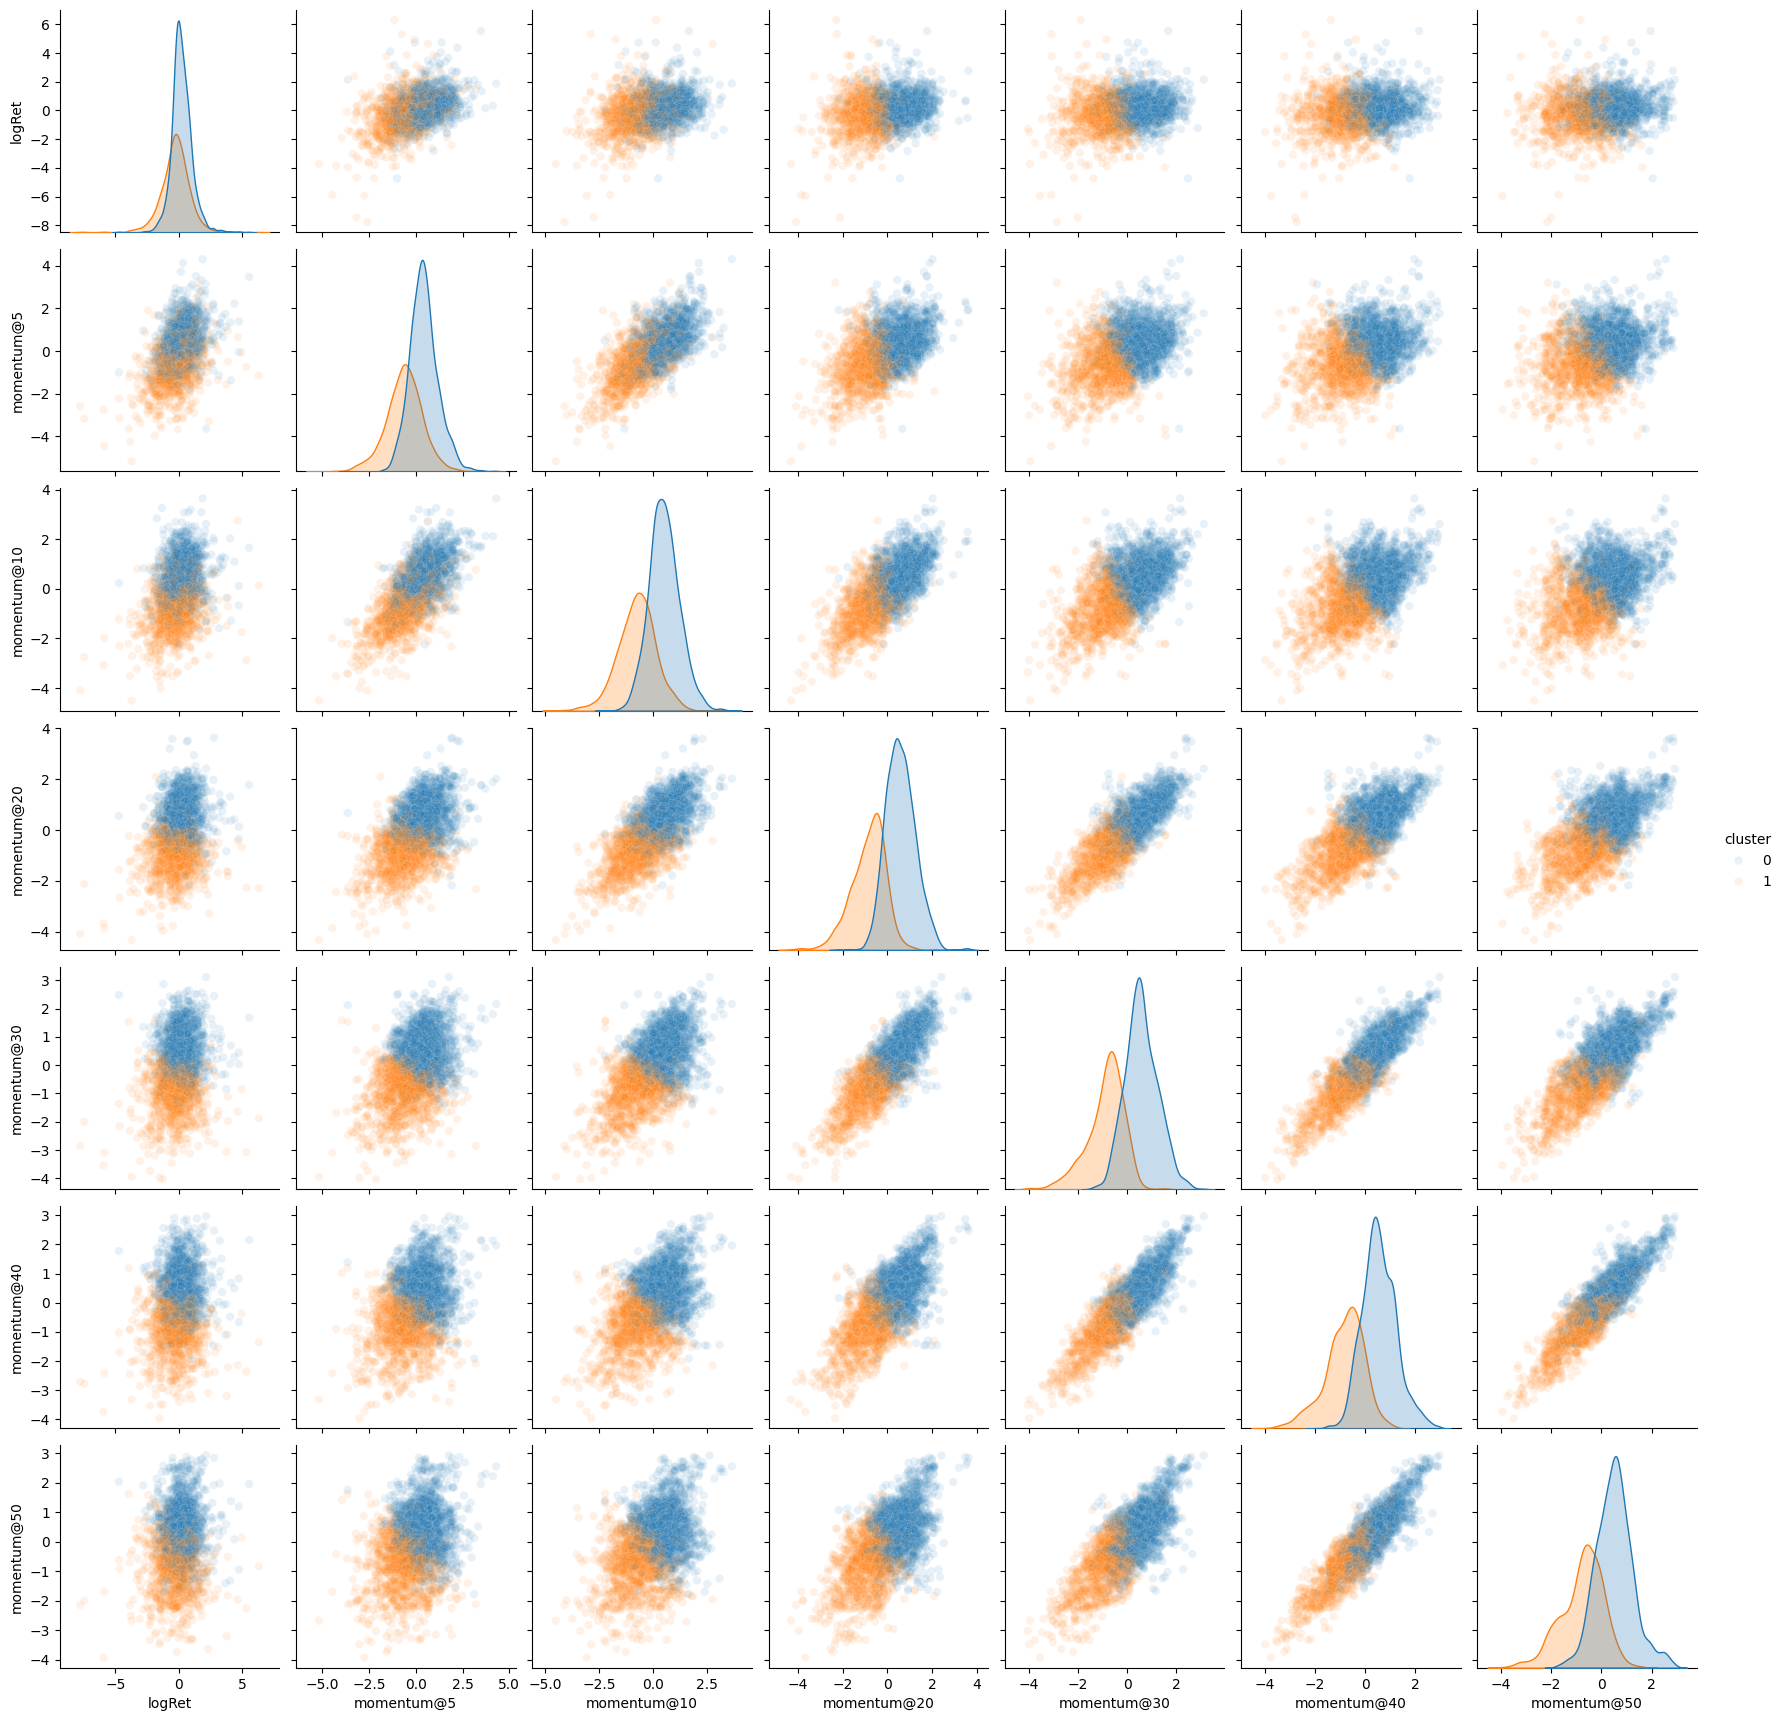

In [18]:
sns.pairplot(df_clusters, hue="cluster", kind='scatter', plot_kws={'alpha':0.1})
plt.show()

Intentemos ahora analizar un valor de K mayor.

In [19]:
n_clusters = 15 # Pon múltiplos de 3 para dibujar los patrones bien
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
kmeans.fit(dataset)
clusters = kmeans.predict(dataset)

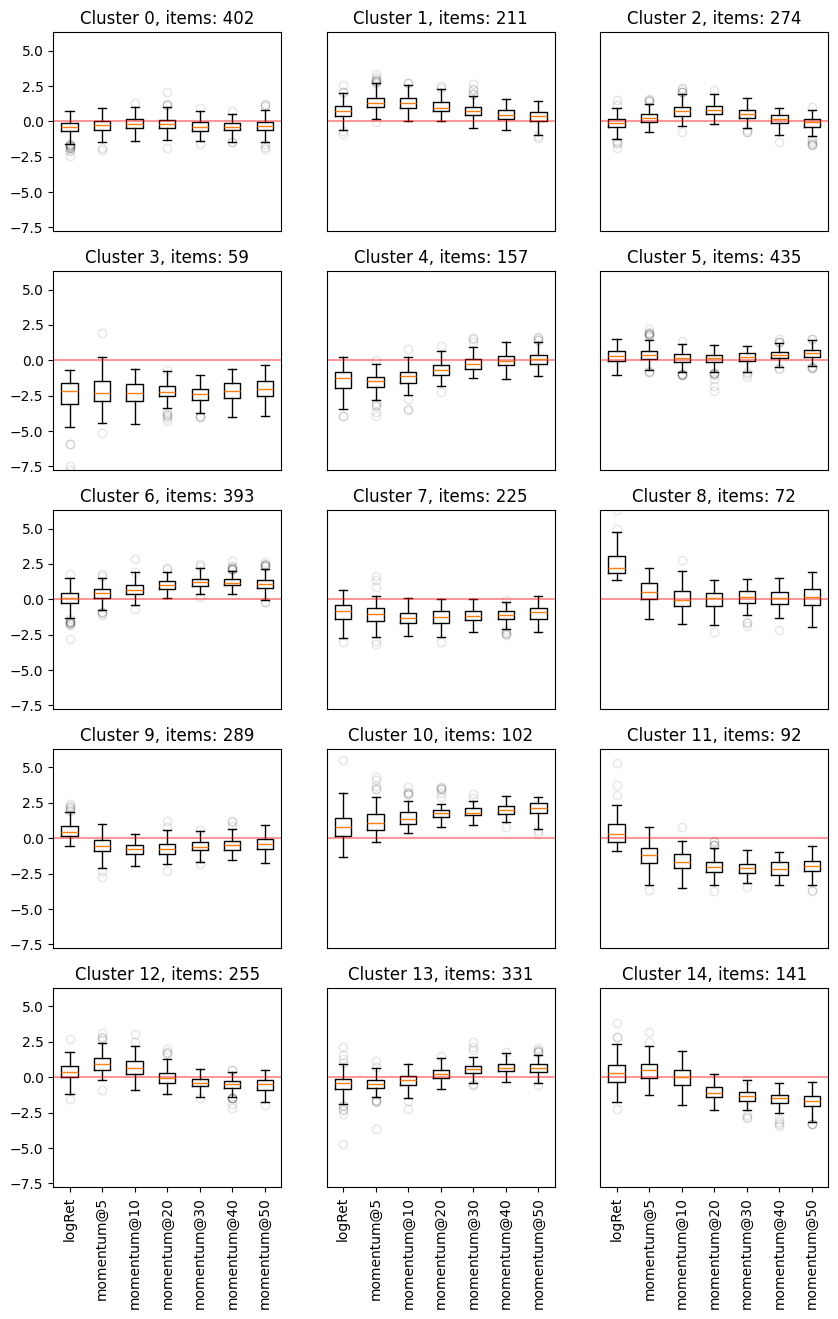

In [20]:
filas = n_clusters // 3
columnas = n_clusters // filas
plt.figure(figsize=(10, 3*filas))
for c in range(n_clusters):
    indices = (clusters == c)
    datos = dataset[indices]
    plt.subplot(filas, columnas, c+1)
    plt.boxplot(datos, flierprops={"alpha":0.1})
    plt.ylim(dataset.min(), dataset.max())
    plt.title("Cluster "+str(c)+", items: "+str(indices.sum()))
    plt.axhline(0.0, color="red", alpha=0.4)
    if c % columnas != 0:
        plt.yticks([])
    if c // columnas < filas-1:
        plt.xticks([])
    else:
        plt.xticks(range(1, dataset.shape[1]+1), lista_atributos, rotation=90)
plt.show()

**Pregunta** ¿Qué conclusiones podemos sacar de este resultado?

Visualicemos de nuevo con los clusters formados.

In [21]:
df_clusters = pd.concat([df, pd.Series(clusters, name='cluster', index=df.index)], axis=1)
df_clusters.sample(5)

logRet  momentum@5  momentum@10  momentum@20  momentum@30  \
2675  1.986820   -0.222062    -1.031484    -0.416467     0.157841   
2019 -1.367728   -2.121621    -1.808567    -1.061067     0.379170   
2432 -0.105018    0.440747     1.259836     1.187623     1.339951   
2036 -0.179648    0.682198     0.488518    -0.058942    -0.235713   
14    0.193986    0.397100     0.797837     0.739077     1.787711   

      momentum@40  momentum@50  cluster  
2675    -1.533333    -0.425850        9  
2019    -0.647092    -0.817407        4  
2432     1.227561     1.610286        6  
2036    -0.041180     0.684561        5  
14       1.592220     0.993305        6

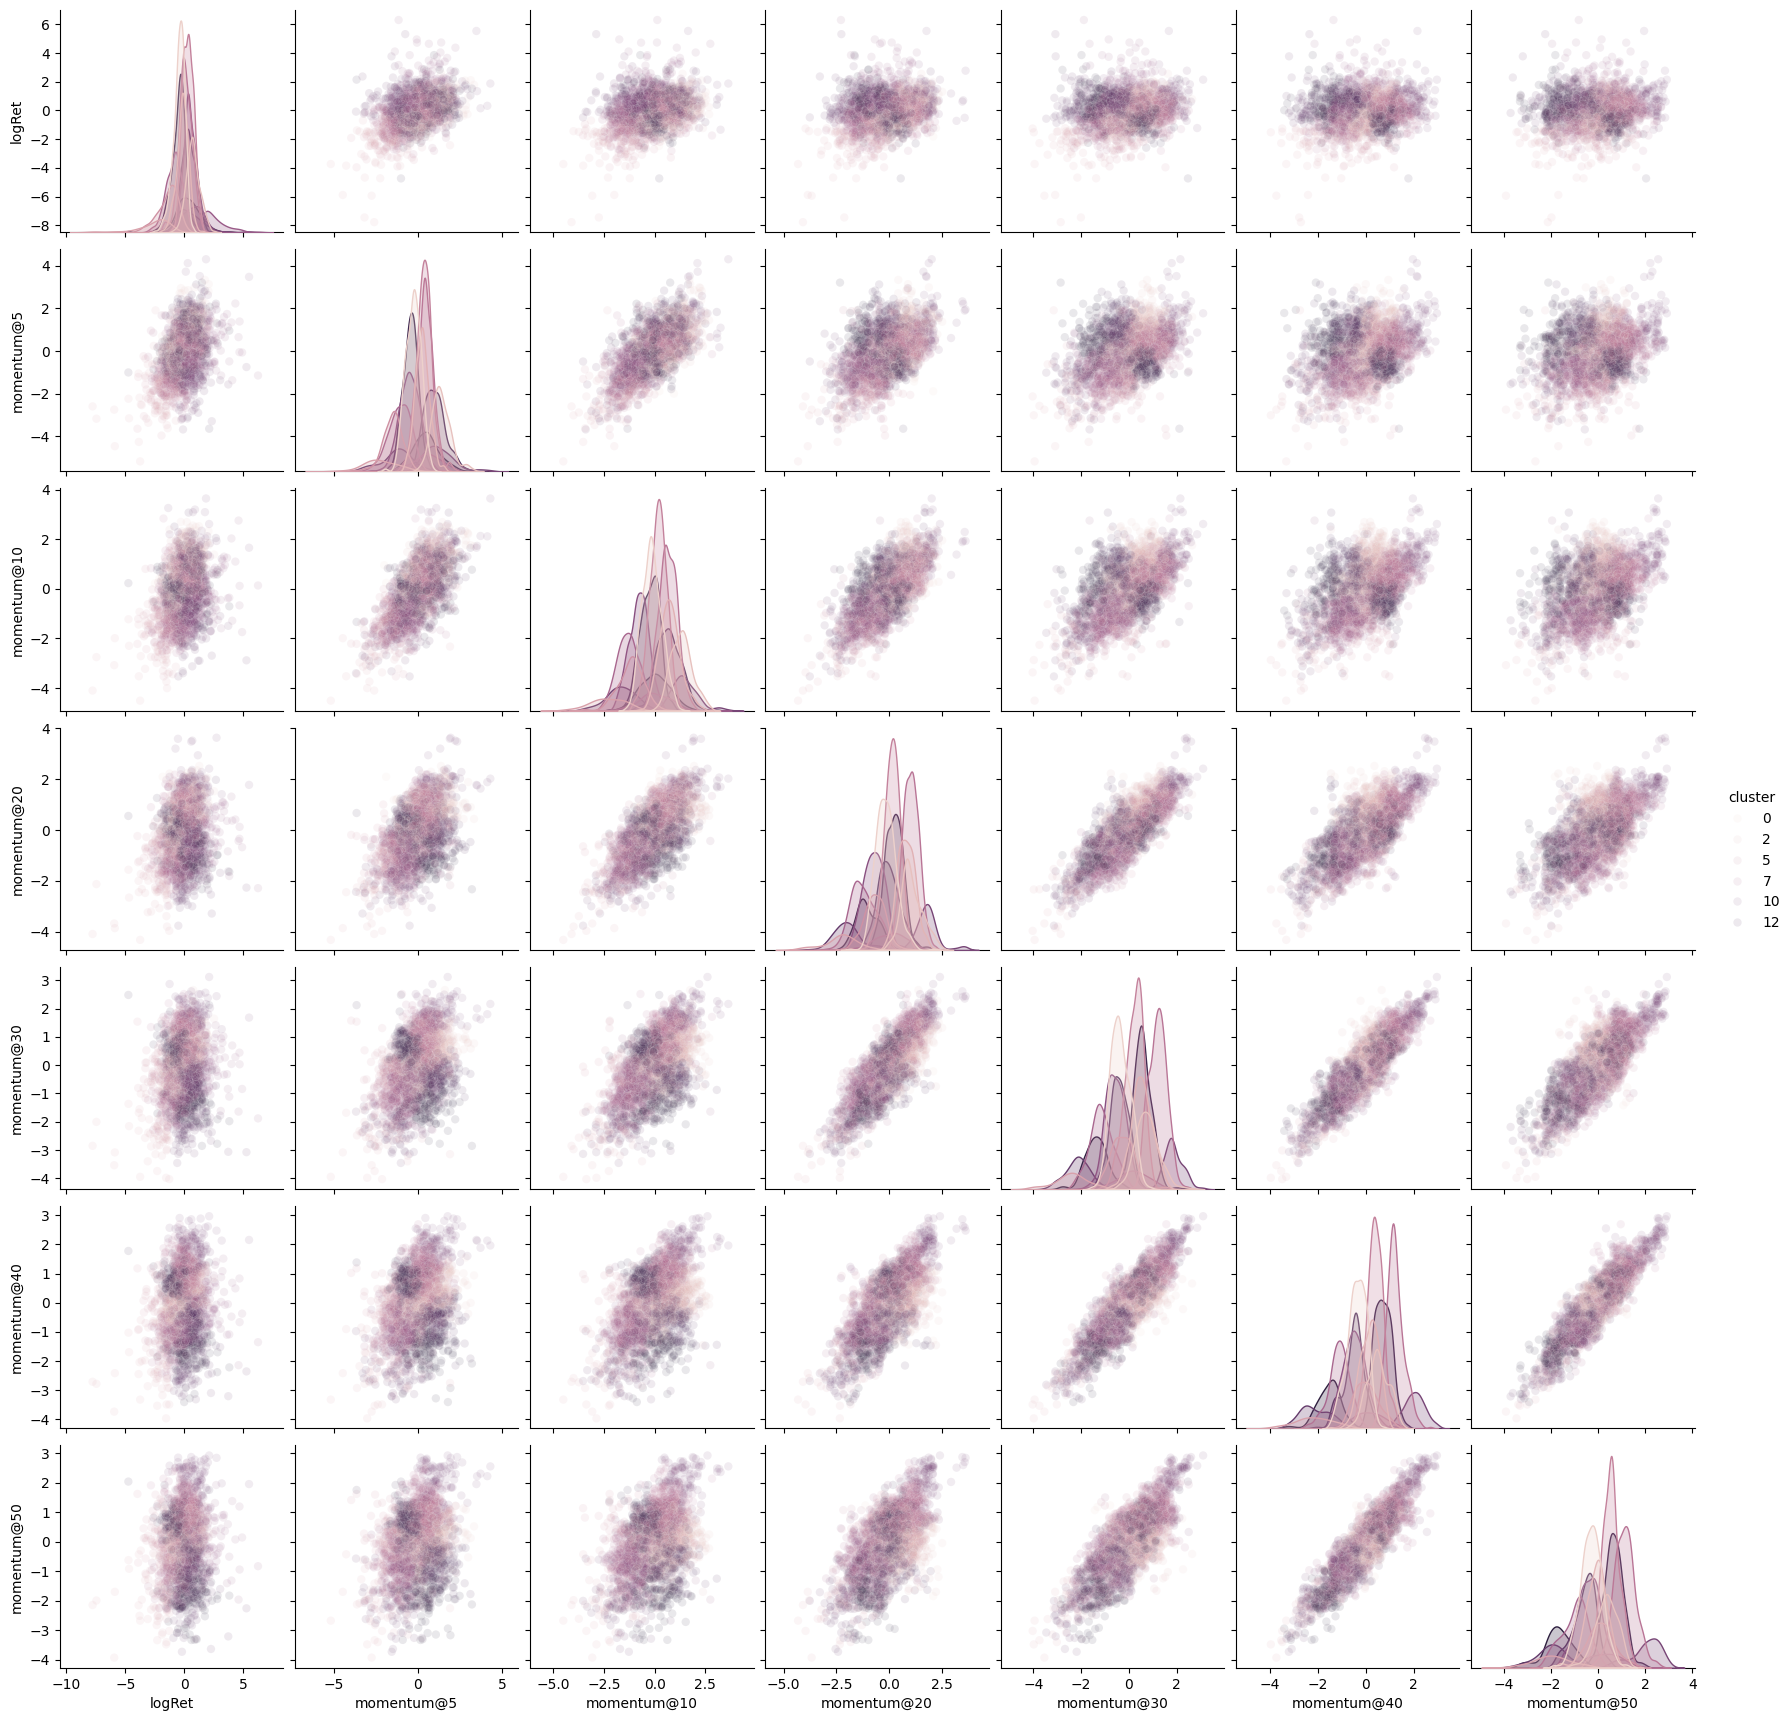

In [22]:
sns.pairplot(df_clusters, hue="cluster", kind='scatter', plot_kws={'alpha':0.1})
plt.show()

## Transformar OHLC a vector de características

Si tenemos un algoritmo de clustering entrenado, como KMeans, una idea que se nos podría ocurrir es la siguiente: ¿puedo contar en un activo determinado cuántas veces aparezco en cada cluster a lo largo del tiempo? Y si puedo hacerlo, ¿podría decir que la frecuencia de aparición en estos clusters define también el comportamiento de mi activo en toda su existencia?

Probemos estas cosas con `TSLA`, un activo que no hemos utilizado en el conjunto de activos para hacer clustering.

In [23]:
datos_test, ohlc = preprocesar_activo("TSLA")
datos_test = (datos_test - means) / stds # Recuerda normalizar los datos con las medias y stds de "los datos conocidos"
clusters_test = kmeans.predict(datos_test)

[*********************100%%**********************]  1 of 1 completed


In [24]:
# Contemos cuántas veces el Kmeans agrupa el activo en cada cluster a lo largo del tiempo
vector = np.zeros(n_clusters)
for c in clusters_test:
    vector[c] += 1
    
# Deberíamos normalizar el vector para compararlo con otros activos. No es necesario ahora
# vector = vector / vector.sum()

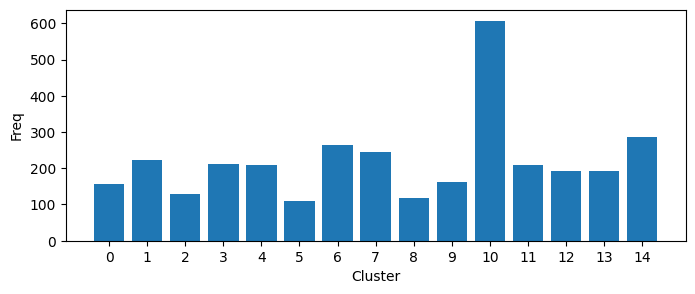

In [28]:
plt.figure(figsize=(8, 3))
plt.bar(range(n_clusters), vector)
plt.xticks(range(n_clusters))
plt.xlabel("Cluster")
plt.ylabel("Freq")
plt.show()

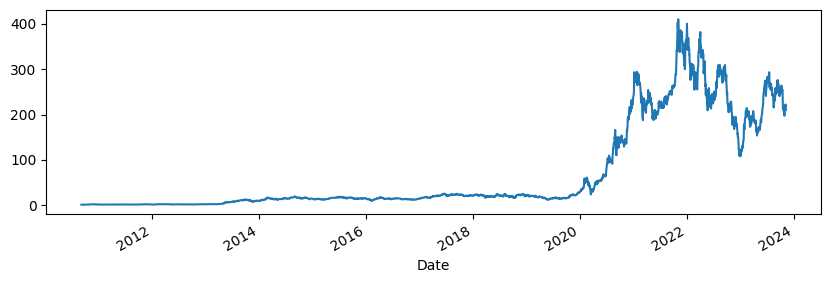

In [29]:
ohlc["Adj Close"].plot(figsize=(10, 3))
plt.show()

**Discusión**: ¿Qué podemos deducir de estas figuras?